**Use GPU: Runtime -> Change runtime type -> GPU (Hardware Accelerator)**

Setup

In [ ]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

Mini-VGGNet

In [ ]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [ ]:
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Learning Rate Decay

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def step_decay(epoch):
	# initialize the base initial learning rate, drop factor, and
	# epochs to drop every
	initAlpha = 0.01
	factor = 0.5
	dropEvery = 5

	# compute learning rate for the current epoch
	alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))

	# return the learning rate
	return float(alpha)

Train Mini-VGGNet (CIFAR10) w/ Learning Rate Decay

In [ ]:
def train_minivggnet_cifar_lr_decay():
    # load the training and testing data, then scale it into the
    # range [0, 1]
    print("[INFO] loading CIFAR-10 data...")
    ((trainX, trainY), (testX, testY)) = cifar10.load_data()
    trainX = trainX.astype("float") / 255.0
    testX = testX.astype("float") / 255.0

    # convert the labels from integers to vectors
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.transform(testY)

    # initialize the label names for the CIFAR-10 dataset
    labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # define the set of callbacks to be passed to the model during
    # training
    callbacks = [LearningRateScheduler(step_decay)]

    # initialize the optimizer and model
    opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, callbacks=callbacks, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=64)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))
    
    return H

In [ ]:
H = train_minivggnet_cifar_lr_decay()

[INFO] loading CIFAR-10 data...
Epoch 1/40
782/782 [==============================] - 8s 9ms/step - loss: 1.9643 - accuracy: 0.3827 - val_loss: 1.4178 - val_accuracy: 0.4977
Epoch 2/40
782/782 [==============================] - 7s 9ms/step - loss: 1.2049 - accuracy: 0.5808 - val_loss: 1.1710 - val_accuracy: 0.5944
Epoch 3/40
782/782 [==============================] - 7s 9ms/step - loss: 0.9953 - accuracy: 0.6561 - val_loss: 0.8938 - val_accuracy: 0.6857
Epoch 4/40
782/782 [==============================] - 7s 9ms/step - loss: 0.8735 - accuracy: 0.6947 - val_loss: 0.7590 - val_accuracy: 0.7449
Epoch 5/40
782/782 [==============================] - 7s 9ms/step - loss: 0.7528 - accuracy: 0.7346 - val_loss: 0.6951 - val_accuracy: 0.7586
Epoch 6/40
782/782 [==============================] - 7s 9ms/step - loss: 0.6821 - accuracy: 0.7575 - val_loss: 0.6724 - val_accuracy: 0.7682
Epoch 7/40
782/782 [==============================] - 7s 9ms/step - loss: 0.6453 - accuracy: 0.7705 - val_loss: 0.65

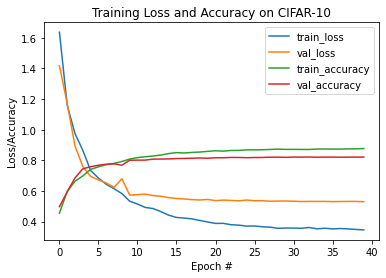

In [ ]:
# plot the training loss and accuracy
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()